<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Можно ли использовать сверточные сети для классификации текстов? Если нет обоснуйте :D, если да то как? как решить проблему с произвольной длинной входа?

<Ответ>

**Вопрос 2**: Чем LSTM лучше/хуже чем обычная RNN?

<Ответ>

**Вопрос 3**:  Выпишите производную $\frac{d c_{n+1}}{d c_{k}}$ для LSTM http://colah.github.io/posts/2015-08-Understanding-LSTMs/, объясните формулу, когда производная затухает, когда взрывается?

<Ответ>

**Вопрос 4**: Зачем нужен TBPTT почему BPTT плох?

<Ответ>


**Вопрос 5**: Как комбинировать рекуррентные и сверточные сети, а главное зачем? Приведите несколько примеров реальных задач.

<Ответ>

**Вопрос 6**: Объясните интуицию выбора размера эмбединг слоя? почему это опасное место?

<Ответ>

* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```, Александр Панин

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline. It can help u https://ars-ashuha.ru/slides/2016.11.11_ImageCaptioning/image_captionong.pdf 

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.

In [1]:
!wget https://www.dropbox.com/s/d50pqlm19c6f6w5/data.tar.gz?dl=0 -O data.tar.gz
!tar -xvzf data.tar.gz

--2017-05-02 17:30:17--  https://www.dropbox.com/s/d50pqlm19c6f6w5/data.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/vXlBvgOgfOMjZeIeBeqvaRoySAEuNJyWOfXASGIVSrHSsv1639aSDignif2b1WZF/file [following]
--2017-05-02 17:30:18--  https://dl.dropboxusercontent.com/content_link/vXlBvgOgfOMjZeIeBeqvaRoySAEuNJyWOfXASGIVSrHSsv1639aSDignif2b1WZF/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.65.6
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.65.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 506221998 (483M) [application/octet-stream]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>] 482.77M  58.8MB/s    in 8.3s    

2017-05-02 17:30:27 (58.3 MB/s) - ‘data.tar.gz’ saved [5062

### Data preprocessing

In [1]:
%%time
# Read Dataset
import numpy as np
import pickle

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 2.76 s, sys: 676 ms, total: 3.44 s
Wall time: 3.44 s


In [2]:
print "each image code is a 1000-unit vector:", img_codes.shape
print img_codes[0,:10]
print '\n\n'
print "for each image there are 5-7 descriptions, e.g.:\n"
print '\n'.join(captions[0])

each image code is a 1000-unit vector: (123287, 1000)
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [3]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [4]:
# Build a Vocabulary

############# TO CODE IT BY YOURSELF ##################
from collections import Counter
word_counter = Counter()
for caption in captions:
    for sentence_list in caption:
        word_counter.update(Counter(sentence_list))

#word_counts = <here should be dict word:number of entrances>
word_counts = dict(word_counter)

vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [5]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [6]:
#try it out on several descriptions of a random image
as_matrix(captions[317])

array([[ 9003,  7201,  9763,  8457,  7201,  6680,  7975,  6722,  4467,
          596,  1392,  6680,  9774,  2653,  7002,  4976],
       [ 9003,  7201,  9763,  7968,  1874,  7201,  6680,  7960, 10361,
         6210,  4976,    -1,    -1,    -1,    -1,    -1],
       [ 9003,  9763,  3185,  9788,  9774,  8315,  1874,  7201,  6804,
         6680,  4976,    -1,    -1,    -1,    -1,    -1],
       [ 9003,  7201,  8257,  6680,  6199,  7975,  6722,  8317,  9707,
         7201,  3601,  4976,    -1,    -1,    -1,    -1],
       [ 9003,  4288,  5401,  8838,  9281,  9707,  7201,  9763,  1874,
           80,  1453,  4976,    -1,    -1,    -1,    -1]], dtype=int32)

### Mah Neural Network

In [7]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 70 #pls change me if u want
LSTM_UNITS = 1024 #pls change me if u want

In [8]:
import theano
import lasagne
import theano.tensor as T
from lasagne.layers import *

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5110)


In [9]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences, PAD_ix)

In [10]:
#network inputs
l_words = InputLayer((None, None), sentences)
l_mask = InputLayer((None, None), sentence_mask)

#embeddings for words 
############# TO CODE IT BY YOURSELF ##################
l_word_embeddings = EmbeddingLayer(l_words, n_tokens, EMBED_SIZE)

In [11]:
# input layer for image features
l_image_features = InputLayer((None, CNN_FEATURE_SIZE), image_vectors)

############# TO CODE IT BY YOURSELF ##################
#convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
#it's also a good idea to add some dropout here and there
l_image_features_small = DropoutLayer(l_image_features,p=0.2)
l_image_features_small = DenseLayer(l_image_features_small, num_units=LSTM_UNITS)
assert l_image_features_small.output_shape == (None, LSTM_UNITS)

In [34]:
############# TO CODE IT BY YOURSELF ##################
# Concatinate image features and word embedings in one sequence 
decoder = LSTMLayer(l_word_embeddings,
                    num_units=LSTM_UNITS,
                    cell_init=l_image_features_small,
                    mask_input=l_mask,
                    grad_clipping=0)

In [35]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer,UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder, (0, 1))
print "broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape

predicted_probabilities_each_tick = DenseLayer(
    broadcast_decoder_ticks,n_tokens, nonlinearity=lasagne.nonlinearities.softmax)

#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(
    predicted_probabilities_each_tick, broadcast_layer=broadcast_decoder_ticks)

print "output shape = ", predicted_probabilities.output_shape

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, None, 10373)

broadcasted decoder shape =  (None, 1024)
output shape =  (None, None, 10373)


In [36]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

#write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:, :-1].reshape((-1, n_tokens)),
    reference_answers.reshape((-1,))
).reshape(reference_answers.shape)

############# TO CODE IT BY YOURSELF ##################
loss = loss[output_mask.nonzero()].mean()

In [37]:
#trainable NN weights
############# TO CODE IT BY YOURSELF ##################
weights = lasagne.layers.get_all_params(predicted_probabilities,trainable=True)
updates = lasagne.updates.adam(loss, weights)#, learning_rate=0.1e-5)
# updates = lasagne.updates.momentum(tloss,
#                                    weights,
#                                    learning_rate=0.01,
#                                    momentum=0.9)

In [38]:
#compile a function that takes input sentence and image mask, outputs loss and updates weights
#please not that your functions must accept image features as FIRST param and sentences as second one
############# TO CODE IT BY YOURSELF ##################
train_step = theano.function([image_vectors,sentences],loss,updates=updates,allow_input_downcast=True)
val_step = theano.function([image_vectors,sentences],loss,updates=None,allow_input_downcast=True)

# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [27]:
captions = np.array(captions)

In [39]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(images), size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = map(choice, captions_for_batch_images)
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [40]:
generate_batch(img_codes,captions, 3)

(array([[-0.1539036 ,  6.00137472,  0.97970736, ...,  2.46454024,
          5.25968504,  1.36904359],
        [-5.1311388 , -1.54078007, -1.17932343, ..., -2.24831367,
         -1.58118761,  8.13486195],
        [-4.16054964, -3.31503129, -2.72506618, ..., -3.75295997,
         -1.87495577,  3.01105642]], dtype=float32),
 array([[9003, 4084, 5034, 3961, 6142, 9707, 1336, 9704, 7201,  161, 4976,
           -1,   -1,   -1],
        [9003, 6722, 5401, 9317, 7968, 4251,  596, 5799, 6745, 4976,   -1,
           -1,   -1,   -1],
        [9003, 7971, 7968, 3233, 5689, 1580, 7191, 6787,  634, 3671,  447,
         3834, 7574, 4976]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [92]:
batch_size = 200 #adjust me
n_epochs   = 1000 #adjust me
n_batches_per_epoch = 500 #adjust me
n_validation_batches = 5 #how many batches are used for validation after each epoch

In [93]:
from tqdm import tqdm

for epoch in range(n_epochs):
    batch_size += 2
    n_batches_per_epoch += 5
    
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")


  1%|          | 6/505 [00:04<05:36,  1.49it/s]

  0%|          | 0/510 [00:00<?, ?it/s]


Epoch: 0, train loss: 1.96090907201, val loss: 1.95635626316


  0%|          | 0/515 [00:00<?, ?it/s]


Epoch: 1, train loss: 1.94318922828, val loss: 1.96030118465


  0%|          | 0/520 [00:00<?, ?it/s]


Epoch: 2, train loss: 1.93178219587, val loss: 1.92470140457


  0%|          | 0/525 [00:00<?, ?it/s]


Epoch: 3, train loss: 1.92360371558, val loss: 1.91577711105


  0%|          | 0/530 [00:00<?, ?it/s]


Epoch: 4, train loss: 1.91200491724, val loss: 1.90192825794


  0%|          | 0/535 [00:00<?, ?it/s]


Epoch: 5, train loss: 1.90512151223, val loss: 1.87740049362


  0%|          | 0/540 [00:00<?, ?it/s]


Epoch: 6, train loss: 1.89474045918, val loss: 1.88824920654


  0%|          | 0/545 [00:00<?, ?it/s]


Epoch: 7, train loss: 1.8839275859, val loss: 1.8898706913


  0%|          | 0/550 [00:00<?, ?it/s]


Epoch: 8, train loss: 1.87334773169, val loss: 1.8917737484


  0%|          | 0/555 [00:00<?, ?it/s]


Epoch: 9, train loss: 1.86830562462, val loss: 1.87688457966


  0%|          | 0/560 [00:00<?, ?it/s]


Epoch: 10, train loss: 1.86131884343, val loss: 1.83654623032


  0%|          | 0/565 [00:00<?, ?it/s]


Epoch: 11, train loss: 1.85309268853, val loss: 1.83970344067


  0%|          | 0/570 [00:00<?, ?it/s]


Epoch: 12, train loss: 1.84318694878, val loss: 1.81658198833


  0%|          | 0/575 [00:00<?, ?it/s]


Epoch: 13, train loss: 1.83446117347, val loss: 1.84327993393


  2%|▏         | 14/575 [00:10<06:36,  1.41it/s]

KeyboardInterrupt: 

## Нет предела совершенству, и сеть можно ещё обучать и обучать
Ответы на картинках даже становятся ближе к истине при уменьшении loss'a

### on the pictures below net loss is ~2.1

a picture that is in a very small looking white and two people
a picture of a man setting with some food in his hands
a picture of someone using their laptop computer
an image of a group of men in the mirror looking at themselves
a young couple in a white shirt on a cobblestone surface
two photographs each taken in a tiny looking at information
a woman with a lap top and a tie
a white baby in a white shirt and a neck tie
a picture of a woman working on a computer
the woman is talking on the side walk


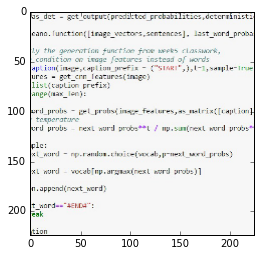

In [86]:
img = plt.imread('data/code.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])

a man doing a trick with his skateboard
a man holding a skateboard and two feet in the air
a person that is playing in the street
a black and white photo of a person holding a skateboard
a boy is hanging out in a big pipe
a man doing a jump with a skateboard
a guy is standing on a skateboard in the street
a white and gray bird underneath a white umbrella
a man standing on a skateboard is doing a trick
a picture of a person doing a jump on a skateboard


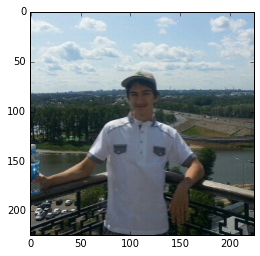

In [90]:
img = plt.imread('data/yaroslavl.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=1.5)[1:-1])

a couple of dark mini and green items
a black and white photograph of two different size images of a man both looking at bananas
two beautiful white images show lots of #UNK#
a white and black picture of a woman leaning back to see through a distance
a picture of the same man on a train
a kid on a skateboard on the pavement
a picture of a suit that is in front of a mirror with a single heart on it
the #UNK# of a white and black covered in white and black double decker #UNK#
a picture of a man on the floor
a black and white photo of a young woman with a #UNK# brace on her head


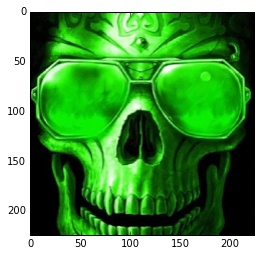

In [91]:
img = plt.imread('data/face.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])

a black and white cat is in the window looking at the camera
a white and brown cat that is sitting down
a black and white photo with a close up of a man who is holding her stuffed bear
a kid with a green #UNK# on a kittens
a white and white cat standing next to a teddy bear
a image of a little girl with a white bow and bow tie
a haired small dog curls into the park
a couple of small animals eating food
a white and brown dog is in a striped chair
a white and white cat sitting in a tree


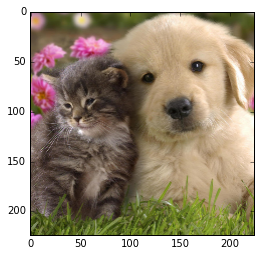

In [89]:
img = plt.imread('data/Dog-and-Cat.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=1.2)[1:-1])

### apply trained model

In [94]:
#the same kind you did last week, but a bit smaller
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl'))['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [67]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread('data/Dog-and-Cat.jpg')
img = preprocess(img)

In [66]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread('data/face.jpg')
img = preprocess(img)

In [146]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread('data/yaroslavl.jpg')
img = preprocess(img)

In [70]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread('data/code.jpg')
img = preprocess(img)

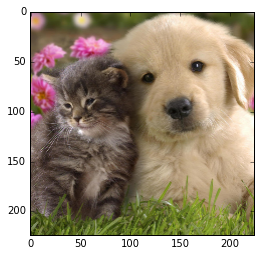

In [68]:
#deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

## Generate caption

In [95]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=1,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

a picture that is in a very small looking white and two people
a picture of a man setting with some food in his hands
a picture of someone using their laptop computer
an image of a group of men in the mirror looking at themselves
a young couple in a white shirt on a cobblestone surface
two photographs each taken in a tiny looking at information
a woman with a lap top and a tie
a white baby in a white shirt and a neck tie
a picture of a woman working on a computer
the woman is talking on the side walk


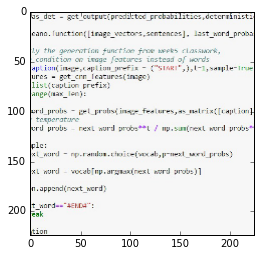

In [86]:
img = plt.imread('data/code.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])

a man doing a trick with his skateboard
a man holding a skateboard and two feet in the air
a person that is playing in the street
a black and white photo of a person holding a skateboard
a boy is hanging out in a big pipe
a man doing a jump with a skateboard
a guy is standing on a skateboard in the street
a white and gray bird underneath a white umbrella
a man standing on a skateboard is doing a trick
a picture of a person doing a jump on a skateboard


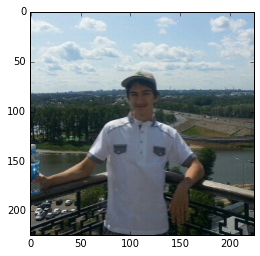

In [90]:
img = plt.imread('data/yaroslavl.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=1.5)[1:-1])

a couple of dark mini and green items
a black and white photograph of two different size images of a man both looking at bananas
two beautiful white images show lots of #UNK#
a white and black picture of a woman leaning back to see through a distance
a picture of the same man on a train
a kid on a skateboard on the pavement
a picture of a suit that is in front of a mirror with a single heart on it
the #UNK# of a white and black covered in white and black double decker #UNK#
a picture of a man on the floor
a black and white photo of a young woman with a #UNK# brace on her head


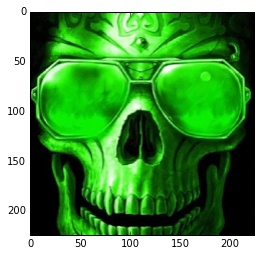

In [91]:
img = plt.imread('data/face.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])

a black and white cat is in the window looking at the camera
a white and brown cat that is sitting down
a black and white photo with a close up of a man who is holding her stuffed bear
a kid with a green #UNK# on a kittens
a white and white cat standing next to a teddy bear
a image of a little girl with a white bow and bow tie
a haired small dog curls into the park
a couple of small animals eating food
a white and brown dog is in a striped chair
a white and white cat sitting in a tree


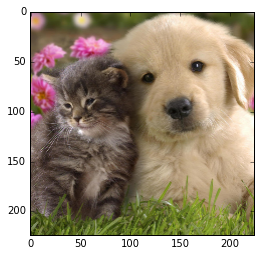

In [89]:
img = plt.imread('data/Dog-and-Cat.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=1.2)[1:-1])

Очень много цветов выводится почему-то.

### on the pictures below net loss is ~1.83 (final loss)

a picture of a man that is standing at a desk
a white and black open field with a book and a laptop
a picture of a woman looking at her cell phone
a woman posing on a bench looking at a watch
a girl and a man looking at a laptop computer
a woman in a white dress standing in front of a laptop
a white and gray open field with a laptop computer on it
a white and black male in a black and white photo with a large box of donuts
a picture of a woman with her tie
a girl is standing at the end of the counter


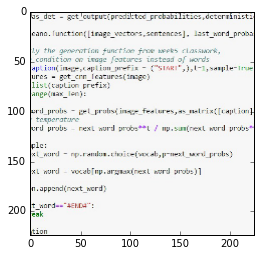

In [106]:
img = plt.imread('data/code.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=2)[1:-1])

a man standing on top of a green skateboard
a man has a skateboard and a hat on the sidewalk
a person on a skateboard waiting for a jump
a white man standing on top of a set of metal board
a man doing a trick with his skateboard
a man in a blue sweater and hat is holding a skateboard
a boy on a skateboard in the air
a man is jumping over the ground on his skateboard
a man in a red suit standing on a street corner
a man standing on a large and black boat


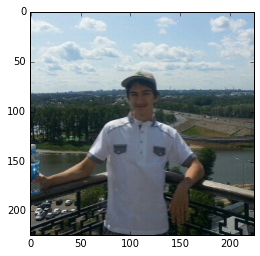

In [97]:
img = plt.imread('data/yaroslavl.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=1.5)[1:-1])

a black and white photo of a small black piece of luggage
a black and white photo of a smiling young boy with a #UNK#
two women taking a picture of they have taken
a couple of beautiful guys looking up at a mirror
a photograph of a woman posing on a chair
a pair of green pants and black umbrellas
the set of a black and white picture of a picture frame and a bag
a picture of three images of a woman with a tennis racket
a picture of a single pair of green luggage
the where the large long hair panel is different sizes


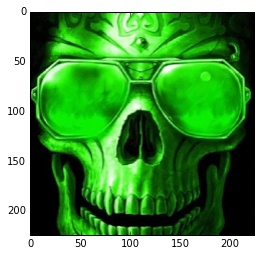

In [103]:
img = plt.imread('data/face.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=1.1)[1:-1])

a white dog is chewing a broccoli in the park
a white and grey dog is looking up
a white dog looks at a piece of paper with its mouth
a white and black dog is in a green room
a white dog who is getting a bath in a tub
a white dog with pink collar on a red and white stripe
a white and black cat is playing with a blue object
a young female that is holding a piece of broccoli
a white and black and white kid attempts to bite on a plastic fork
a yellow and black cat is on a pink and white checkered chair


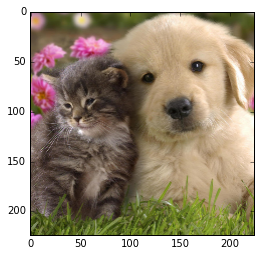

In [99]:
img = plt.imread('data/Dog-and-Cat.jpg')
img = preprocess(img)

plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))
for i in range(10):
    print ' '.join(generate_caption(img,t=1.2)[1:-1])

# Bonus Part
- Use ResNet Instead of GoogLeNet
- Use W2V as embedding
- Use Attention :) 

# Pass Assignment https://goo.gl/forms/2qqVtfepn0t1aDgh1 